# Step 1.2: Formula 1 Data Aggregation Pipeline

This notebook contains the complete pipeline for aggregating various Formula 1 data sources, including:
1.  **Web Scraping:** News articles from *Motorsport Magazine*.
2.  **Kaggle Datasets:** Structured data like tweets, comments, and historical results.
3.  **FastF1:** Technical and real-time race data.
4.  **Data Visualization:** Basic plots from the aggregated data.

Each major task is separated into its own cell, allowing you to run them independently.

### Step 0: Imports and Configuration
Run this cell first to import all necessary libraries and set up the save directory.

In [48]:
import os
import re
import pandas as pd
import requests
from bs4 import BeautifulSoup
import fastf1
import kaggle
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from textblob import TextBlob
from collections import Counter

# --- Configuration ---
# Set the destination for your aggregated data
SAVE_PATH = 'f1_data'
# Ensure the save directory exists
os.makedirs(SAVE_PATH, exist_ok=True)
print(f"Data will be saved in the '{SAVE_PATH}' directory.")

Data will be saved in the 'f1_data' directory.


### Step 1: Scrape News Articles
This function scrapes articles from *Motorsport Magazine* and *Autosport*. The selectors have been updated to reflect the current website layouts.

In [27]:
def scrape_f1_news(max_articles_per_source=500):
    """
    Scrapes news articles from Motorsport Magazine.
    """
    print("Scraping news articles...")
    all_articles = []
    headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}

    # --- Scrape Motorsport Magazine ---
    print("Scraping Motorsport Magazine...")
    today = datetime.today()
    months_to_scrape = 24  # Go back further to find enough articles
    for i in range(months_to_scrape):
        if len([a for a in all_articles if a['source'] == 'Motorsport Magazine']) >= max_articles_per_source:
            break
        
        target_date = today - relativedelta(months=i)
        year = target_date.year
        month_name = target_date.strftime('%B')
        
        page = 1
        while True:
            if len([a for a in all_articles if a['source'] == 'Motorsport Magazine']) >= max_articles_per_source:
                break
            
            try:
                # Handle pagination in the URL
                paginated_url = f'https://www.motorsportmagazine.com/articles/category/single-seaters/f1/page/{page}/?date_query={year}+{month_name}'
                if page == 1:
                     paginated_url = f'https://www.motorsportmagazine.com/articles/category/single-seaters/f1/?date_query={year}+{month_name}'
                
                print(f"Scraping: {paginated_url}")
                response = requests.get(paginated_url, headers=headers, timeout=10)
                
                if response.status_code == 404:
                    print(f"  -> Page {page} not found for {month_name} {year}. Moving to next month.")
                    break
                
                response.raise_for_status()
                soup = BeautifulSoup(response.content, 'html.parser')
                
                articles = soup.select('article.article-item')
                if not articles:
                    print(f"  -> No more articles found for {month_name} {year} on page {page}.")
                    break

                for article in articles:
                    link_element = article.select_one('a.article-item__link')
                    if not link_element:
                        continue

                    title_element = link_element.select_one('h2.article-item__title')
                    summary_element = link_element.select_one('div.article-item__excerpt p')
                    
                    if title_element and summary_element:
                        all_articles.append({
                            'source': 'Motorsport Magazine',
                            'title': title_element.get_text(strip=True),
                            'summary': summary_element.get_text(strip=True),
                            'link': link_element['href']
                        })
                page += 1
                time.sleep(1) # Be respectful to the server

            except requests.exceptions.RequestException as e:
                print(f"Could not scrape Motorsport Magazine page {page} for {month_name} {year}: {e}")
                break

    if all_articles:
        # Save only Motorsport Magazine articles now
        df = pd.DataFrame(all_articles)
        df.to_csv(os.path.join(SAVE_PATH, 'f1_news_articles.csv'), index=False)
        print(f"\nSuccessfully scraped {len(df)} articles from Motorsport Magazine.")
    else:
        print("\nNo articles were scraped from Motorsport Magazine.")

In [26]:
# Run the scraping function
news_df = scrape_f1_news()

Scraping news articles...
Scraping Motorsport Magazine...
Scraping: https://www.motorsportmagazine.com/articles/category/single-seaters/f1/?date_query=2025+October
Scraping: https://www.motorsportmagazine.com/articles/category/single-seaters/f1/page/2/?date_query=2025+October
Scraping: https://www.motorsportmagazine.com/articles/category/single-seaters/f1/page/3/?date_query=2025+October
Scraping: https://www.motorsportmagazine.com/articles/category/single-seaters/f1/page/4/?date_query=2025+October
Scraping: https://www.motorsportmagazine.com/articles/category/single-seaters/f1/page/5/?date_query=2025+October
  -> No more articles found for October 2025 on page 5.
Scraping: https://www.motorsportmagazine.com/articles/category/single-seaters/f1/?date_query=2025+September
Scraping: https://www.motorsportmagazine.com/articles/category/single-seaters/f1/page/2/?date_query=2025+September
Scraping: https://www.motorsportmagazine.com/articles/category/single-seaters/f1/page/3/?date_query=2025+

In [51]:
# def scrape_autosport_results():
#     """
#     Scrapes F1 race results from Autosport for the specified year by first finding
#     individual race links and then scraping each of those pages.
#     """
#     print("\nScraping F1 results from Autosport...")
#     headers = {'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'}
#     all_results_data = []
#     base_url = 'https://www.autosport.com'
    
#     # Let's target 2024 and 2025 to get more data
#     for year in [2024, 2025]:
#         summary_url = f'{base_url}/f1/results/{year}'
        
#         try:
#             print(f"\nFetching race links from: {summary_url}")
#             response = requests.get(summary_url, headers=headers, timeout=10)
#             response.raise_for_status()
#             soup = BeautifulSoup(response.content, 'html.parser')
            
#             race_links = []
#             # Find the main summary table
#             summary_table = soup.select_one('table.ms-racetable tbody')
#             if summary_table:
#                 # Extract the link from the first cell of each row
#                 for row in summary_table.find_all('tr'):
#                     link_tag = row.select_one('td:first-child a')
#                     if link_tag and link_tag.has_attr('href'):
#                         race_links.append(base_url + link_tag['href'])
            
#             if not race_links:
#                 print(f"  -> No race links found for {year}.")
#                 continue

#             # Now, scrape each individual race page
#             for race_url in race_links:
#                 try:
#                     print(f"Scraping detailed results from: {race_url}")
#                     race_response = requests.get(race_url, headers=headers, timeout=10)
#                     race_response.raise_for_status()
#                     race_soup = BeautifulSoup(race_response.content, 'html.parser')
                    
#                     grand_prix_name = race_soup.select_one('h1.ms-item-title__text').get_text(strip=True) if race_soup.select_one('h1.ms-item-title__text') else "Unknown GP"
                    
#                     results_table = race_soup.select_one('table.ms-racetable tbody')
#                     if not results_table:
#                         print(f"  -> Results table not found on {race_url}")
#                         continue

#                     rows = results_table.find_all('tr')
#                     for row in rows:
#                         cells = row.find_all('td')
#                         if len(cells) >= 8: # Detailed view has more columns
#                             pos = cells[0].get_text(strip=True)
#                             driver = cells[2].get_text(strip=True)
#                             team = cells[3].get_text(strip=True)
#                             laps = cells[4].get_text(strip=True)
#                             time_status = cells[5].get_text(strip=True)
                            
#                             all_results_data.append({
#                                 'Year': year,
#                                 'Grand Prix': grand_prix_name,
#                                 'Position': pos,
#                                 'Driver': driver,
#                                 'Team': team,
#                                 'Laps': laps,
#                                 'Time/Status': time_status
#                             })
#                     time.sleep(1) # Be respectful

#                 except requests.exceptions.RequestException as e:
#                     print(f"  -> Could not scrape detailed results page {race_url}: {e}")

#         except requests.exceptions.RequestException as e:
#             print(f"Could not scrape Autosport results summary page for {year}: {e}")
#             continue

#     if all_results_data:
#         df = pd.DataFrame(all_results_data)
#         results_path = os.path.join(SAVE_PATH, 'f1_results_autosport.csv')
#         df.to_csv(results_path, index=False)
#         print(f"\nSuccessfully scraped {len(df)} total race result entries and saved to {results_path}")
#     else:
#         print("\nNo race results were scraped from Autosport.")
    

In [52]:
# races_df = scrape_autosport_results()

### Step 2: Download Kaggle Datasets

In [33]:
def download_kaggle_datasets():
    """
    Downloads F1 datasets from Kaggle.
    """
    print("\nDownloading Kaggle datasets...")
    datasets = {
        'trending_tweets': 'kaushiksuresh147/formula-1-trending-tweets',
        'reddit_comments': 'smagnan/1-million-reddit-comments-from-40-subreddits',
        'fan_ratings': 'codingminds/formula-1-race-fan-ratings',
        'championship_history': 'muhammadehsan02/formula-1-world-championship-history-1950-2024'
    }

    try:
        kaggle.api.authenticate()
        for name, dataset_id in datasets.items():
            print(f"Downloading {name}...")
            path = os.path.join(SAVE_PATH, name)
            if not os.path.exists(path) or not os.listdir(path):
                 kaggle.api.dataset_download_files(dataset_id, path=path, unzip=True)
                 print(f"Successfully downloaded {name}.")
            else:
                 print(f"'{name}' already exists. Skipping download.")
    except Exception as e:
        print(f"Error downloading Kaggle datasets: {e}")
        print("Please ensure your kaggle.json is set up correctly.")

In [34]:
# Run the Kaggle download function
download_kaggle_datasets()


'trending_tweets' already exists. Skipping download.
'reddit_comments' already exists. Skipping download.
'fan_ratings' already exists. Skipping download.
'championship_history' already exists. Skipping download.


### Step 3: Fetch Technical Data with FastF1

In [35]:
def get_fastf1_data():
    """
    Fetches race data for a full season using the FastF1 library.
    """
    print("\nFetching technical data with FastF1...")
    try:
        cache_path = 'fastf1_cache'
        os.makedirs(cache_path, exist_ok=True)
        fastf1.Cache.enable_cache(cache_path)

        year = datetime.now().year - 1
        print(f"Fetching data for the {year} season.")
        schedule = fastf1.get_event_schedule(year)

        races = schedule[schedule['EventDate'] < datetime.now()]

        for index, race in races.head(5).iterrows(): # Limiting to 5 races to run faster
            if race['EventFormat'] == 'conventional':
                try:
                    print(f"Fetching data for: {race['EventName']}")
                    session = fastf1.get_session(year, race['RoundNumber'], 'R')
                    session.load()
                    laps = session.laps
                    laps_path = os.path.join(SAVE_PATH, f"{year}_{race['EventName'].replace(' ', '_')}_laps.csv")
                    laps.to_csv(laps_path, index=False)
                    print(f"  -> Lap data saved to {laps_path}")
                except Exception as e:
                    print(f"  -> Could not load session data for {race['EventName']}: {e}")

    except Exception as e:
        print(f"Could not fetch data using FastF1: {e}")

In [36]:
# Run the FastF1 data function
get_fastf1_data()

core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info



Fetching technical data with FastF1...
Fetching data for the 2024 season.
Fetching data for: Bahrain Grand Prix


req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...
req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '63', '4', '44', '81', '14', '18', '24', '20', '3', '22', '23', '27', '31', '10', '77', '2']
core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_statu

  -> Lap data saved to f1_data\2024_Bahrain_Grand_Prix_laps.csv
Fetching data for: Saudi Arabian Grand Prix


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '16', '81', '14', '63', '38', '4', '44', '27', '23', '20', '31', '2', '22', '3', '77', '24', '18', '10']
core           INFO 	Loading data for Australian Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  -> Lap data saved to f1_data\2024_Saudi_Arabian_Grand_Prix_laps.csv
Fetching data for: Australian Grand Prix


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 19 drivers: ['55', '16', '4', '81', '11', '18', '22', '14', '27', '20', '23', '3', '10', '77', '24', '31', '63', '44', '1']
core           INFO 	Loading data for Japanese Grand Prix - Race [v3.6.1]
req            INFO 	Using cached data for session_info
req            INFO 	Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
core           INFO 	Processing timing data...


  -> Lap data saved to f1_data\2024_Australian_Grand_Prix_laps.csv
Fetching data for: Japanese Grand Prix


req            INFO 	Using cached data for car_data
req            INFO 	Using cached data for position_data
req            INFO 	Using cached data for weather_data
req            INFO 	Using cached data for race_control_messages
core           INFO 	Finished loading data for 20 drivers: ['1', '11', '55', '16', '4', '14', '63', '81', '44', '22', '27', '18', '20', '77', '31', '10', '2', '24', '3', '23']


  -> Lap data saved to f1_data\2024_Japanese_Grand_Prix_laps.csv


### Step 4: Visualize News Data


In [49]:
DATA_PATH = 'f1_data'
NEWS_FILE = os.path.join(DATA_PATH, 'f1_news_articles.csv')
SAVE_PATH = 'f1_data' # Can be the same or different

def plot_word_cloud(df):
    """
    Generates and saves a word cloud from the news article titles.
    """
    print("\nGenerating word cloud...")
    text = " ".join(str(title) for title in df['title'].dropna())
    
    if not text:
        print("No text found for word cloud.")
        return

    stopwords = set(STOPWORDS)
    stopwords.update(["F1", "GP", "Grand", "Prix", "race", "say", "says", "will", "new", "teams", "driver"])

    wordcloud = WordCloud(
        stopwords=stopwords, background_color="white", max_words=100,
        width=1200, height=600, collocations=False
    ).generate(text)

    plt.figure(figsize=(15, 7))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.title('Most Common Words in F1 News Headlines', fontsize=20, pad=20)
    
    output_path = os.path.join(SAVE_PATH, 'visualization_news_wordcloud.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Word cloud saved to {output_path}")

def plot_sentiment_analysis(df):
    """
    Performs sentiment analysis on article titles and plots the distribution.
    NOTE: This requires the TextBlob library. Install it via:
    pip install textblob
    python -m textblob.download_corpora
    """
    print("\nPerforming sentiment analysis...")
    
    def get_sentiment(text):
        analysis = TextBlob(str(text))
        if analysis.sentiment.polarity > 0.05:
            return 'Positive'
        elif analysis.sentiment.polarity < -0.05:
            return 'Negative'
        else:
            return 'Neutral'

    df['sentiment'] = df['title'].apply(get_sentiment)

    plt.figure(figsize=(8, 6))
    sns.countplot(x='sentiment', data=df, palette={'Positive': 'g', 'Neutral': 'b', 'Negative': 'r'}, order=['Positive', 'Neutral', 'Negative'])
    plt.title('Sentiment of F1 News Headlines', fontsize=16)
    plt.xlabel('Sentiment', fontsize=12)
    plt.ylabel('Number of Articles', fontsize=12)
    
    output_path = os.path.join(SAVE_PATH, 'visualization_sentiment_analysis.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"Sentiment analysis plot saved to {output_path}")

def plot_entity_mentions(df):
    """
    Counts mentions of top F1 drivers and teams in headlines and plots the results.
    """
    print("\nAnalyzing driver and team mentions...")
    
    # List of drivers and teams to track (using last names for simplicity)
    drivers = ['Verstappen', 'Hamilton', 'Norris', 'Leclerc', 'Sainz', 'Piastri', 'Russell', 'Perez', 'Alonso', 'Gasly']
    teams = ['Red Bull', 'Mercedes', 'McLaren', 'Ferrari', 'Aston Martin', 'Alpine', 'Williams']

    text = " ".join(str(title) for title in df['title'].dropna())
    
    # Use regex to find whole words to avoid partial matches (e.g., 'art' in 'Martin')
    driver_counts = Counter()
    for driver in drivers:
        driver_counts[driver] = len(re.findall(r'\b' + re.escape(driver) + r'\b', text, re.IGNORECASE))

    team_counts = Counter()
    for team in teams:
        team_counts[team] = len(re.findall(r'\b' + re.escape(team) + r'\b', text, re.IGNORECASE))

    # Create subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 14))
    
    # Plot Top Driver Mentions
    top_drivers = dict(driver_counts.most_common(10))
    sns.barplot(x=list(top_drivers.values()), y=list(top_drivers.keys()), ax=ax1, palette='mako')
    ax1.set_title('Top 10 Most Mentioned Drivers in Headlines', fontsize=16)
    ax1.set_xlabel('Number of Mentions', fontsize=12)
    ax1.set_ylabel('Driver', fontsize=12)

    # Plot Top Team Mentions
    top_teams = dict(team_counts.most_common(10))
    sns.barplot(x=list(top_teams.values()), y=list(top_teams.keys()), ax=ax2, palette='rocket')
    ax2.set_title('Most Mentioned Teams in Headlines', fontsize=16)
    ax2.set_xlabel('Number of Mentions', fontsize=12)
    ax2.set_ylabel('Team', fontsize=12)
    
    plt.tight_layout(pad=3.0)
    output_path = os.path.join(SAVE_PATH, 'visualization_entity_mentions.png')
    plt.savefig(output_path)
    plt.show()
    plt.close()
    print(f"Entity mentions plot saved to {output_path}")

Attempting to load data from: f1_data\f1_news_articles.csv

Generating word cloud...


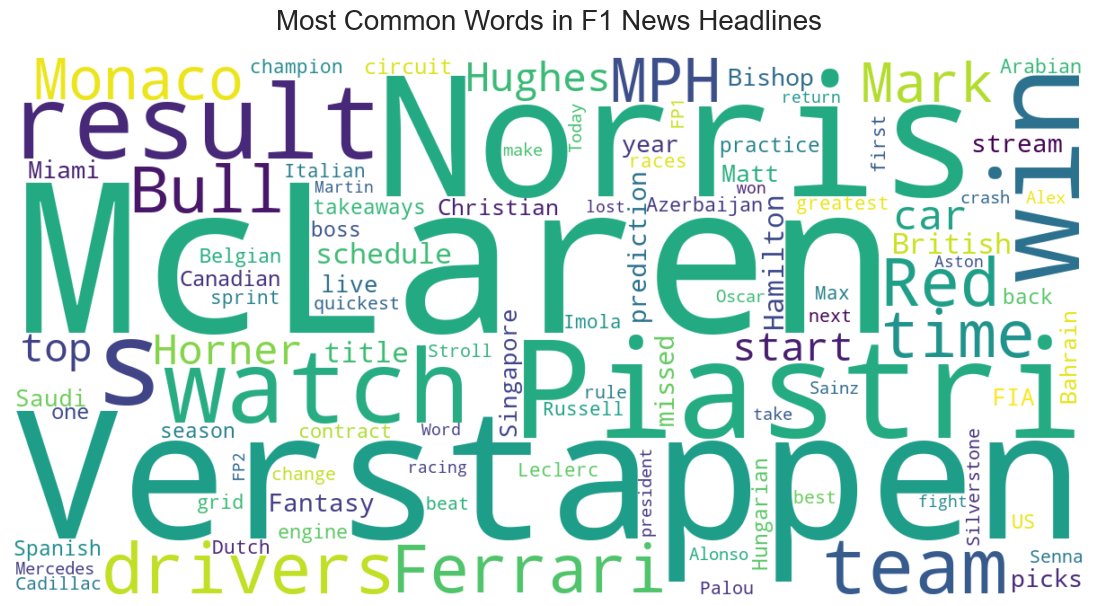

Word cloud saved to f1_data\visualization_news_wordcloud.png

Performing sentiment analysis...


C:\Users\zengq\AppData\Local\Temp\ipykernel_39800\3970113838.py:56: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='sentiment', data=df, palette={'Positive': 'g', 'Neutral': 'b', 'Negative': 'r'}, order=['Positive', 'Neutral', 'Negative'])


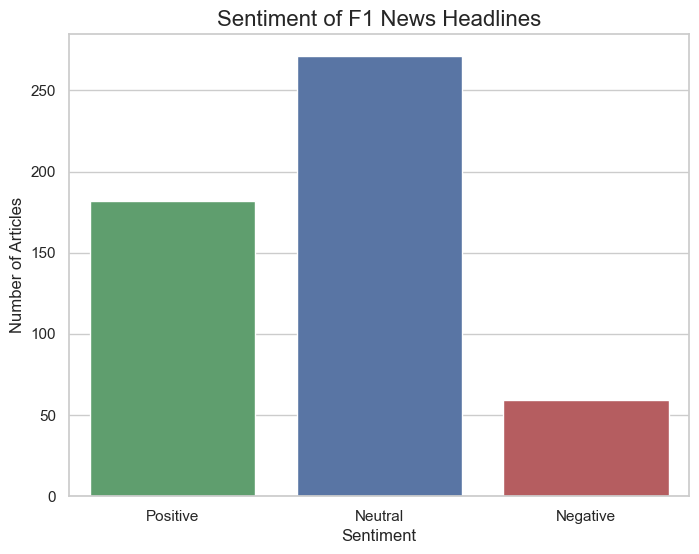

C:\Users\zengq\AppData\Local\Temp\ipykernel_39800\3970113838.py:93: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_drivers.values()), y=list(top_drivers.keys()), ax=ax1, palette='mako')
C:\Users\zengq\AppData\Local\Temp\ipykernel_39800\3970113838.py:100: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(top_teams.values()), y=list(top_teams.keys()), ax=ax2, palette='rocket')


Sentiment analysis plot saved to f1_data\visualization_sentiment_analysis.png

Analyzing driver and team mentions...


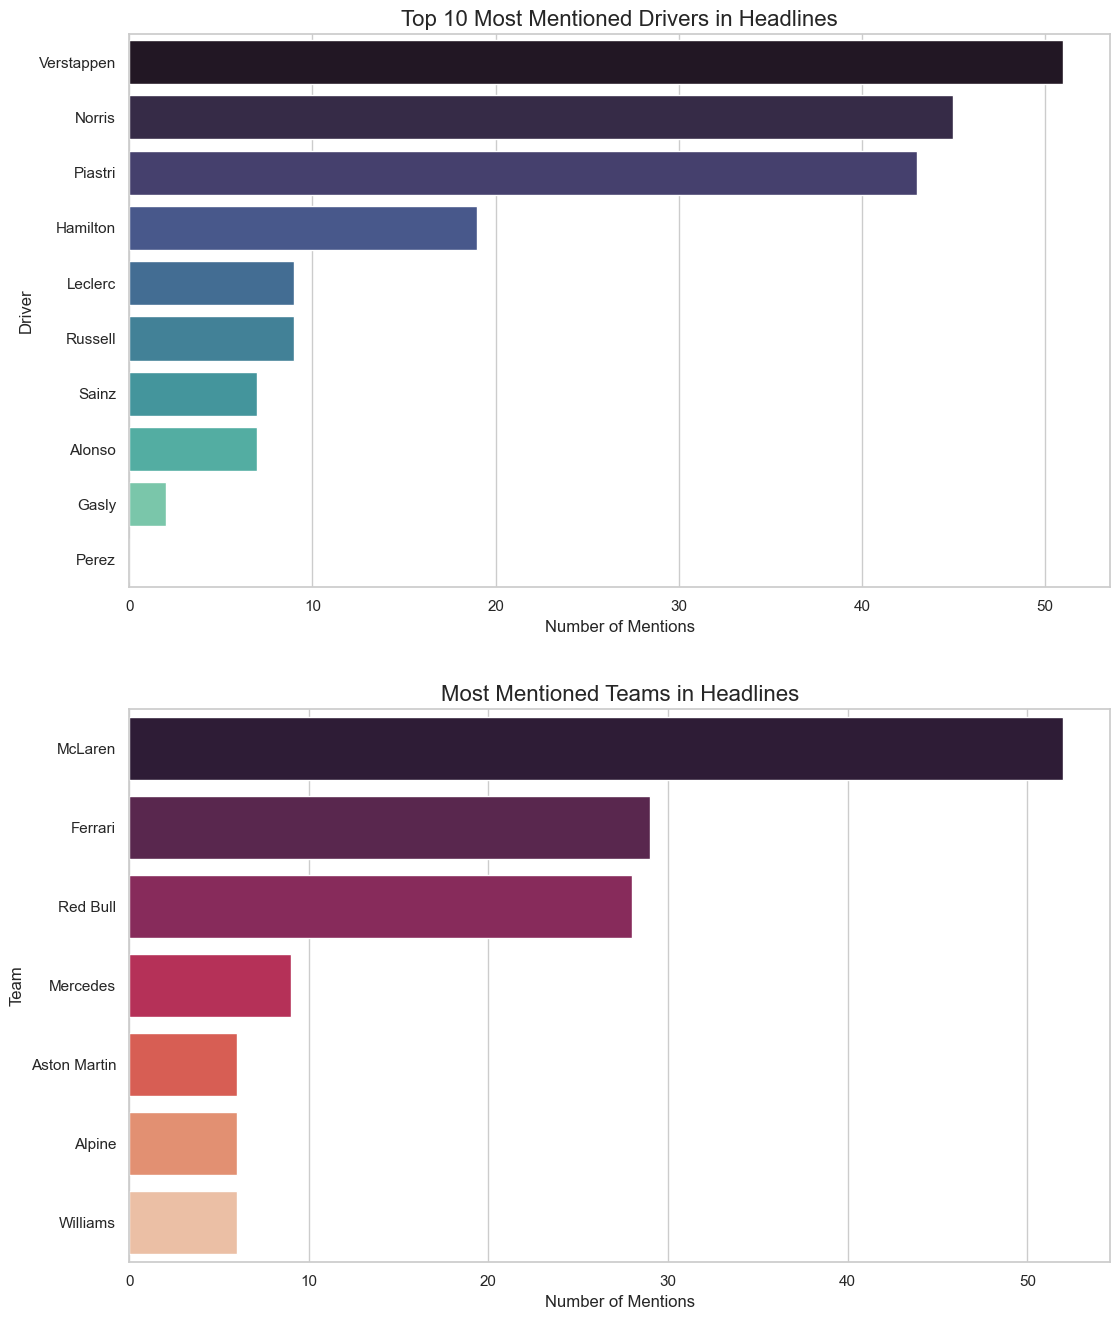

Entity mentions plot saved to f1_data\visualization_entity_mentions.png


In [50]:
try:
        print(f"Attempting to load data from: {NEWS_FILE}")
        news_df = pd.read_csv(NEWS_FILE)
        
        # --- Run Visualizations ---
        plot_word_cloud(news_df)
        plot_sentiment_analysis(news_df)
        plot_entity_mentions(news_df)
        
except FileNotFoundError:
    print(f"Error: The file was not found at {NEWS_FILE}")
    print("Please ensure the main data aggregation script has been run successfully.")
except ImportError as e:
    print(f"Error: A required library is not installed: {e.name}")
    print("Please install it. For TextBlob, you may also need to download data: python -m textblob.download_corpora")
except Exception as e:
    print(f"An unexpected error occurred: {e}")


### Step 5: Visualize Kaggle Data

In [55]:
# --- Configuration ---
# Assumes the script is run from the project root directory
DATA_PATH = os.path.join('f1_data')
SAVE_PATH = 'f1_data'

# --- File Paths ---
RATINGS_FILE = os.path.join(DATA_PATH, 'fan_ratings', 'aggregated_kaggle.csv')
DRIVERS_FILE = os.path.join(DATA_PATH, 'championship_history', 'Driver_Details.csv')
RESULTS_FILE = os.path.join(DATA_PATH, 'championship_history', 'Driver_Rankings.csv')
TWEETS_FILE = os.path.join(DATA_PATH, 'trending_tweets', 'F1_tweets.csv')

def plot_top_champions(drivers_df, results_df):
    """
    Calculates and plots the drivers with the most F1 race wins.
    """
    print("\n1. Visualizing Top Race Winners...")
    winners = results_df[results_df['position'] == 1]
    win_counts = winners.groupby('driverId').size().sort_values(ascending=False).reset_index(name='wins')
    
    # Merge with driver names
    win_counts = win_counts.merge(drivers_df, on='driverId')
    win_counts['Driver'] = win_counts['forename'] + ' ' + win_counts['surname']
    
    top_10_winners = win_counts.head(10)

    # 

    plt.figure(figsize=(12, 8))
    sns.barplot(x='wins', y='Driver', data=top_10_winners, palette='viridis')
    plt.title('Top 10 F1 Drivers by Race Wins (Historical)', fontsize=16)
    plt.xlabel('Number of Race Wins', fontsize=12)
    plt.ylabel('Driver', fontsize=12)
    
    output_path = os.path.join(SAVE_PATH, 'visualization_top_race_winners.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"   - Top winners plot saved to {output_path}")

def plot_fan_ratings_over_time(ratings_df):
    """
    Plots the average fan rating for F1 races over the years.
    """
    print("\n2. Visualizing Fan Ratings Over Time...")
    ratings_df['year'] = pd.to_datetime(ratings_df['race_date']).dt.year
    avg_rating_by_year = ratings_df.groupby('year')['rating'].mean().reset_index()

    plt.figure(figsize=(14, 7))
    sns.lineplot(x='year', y='rating', data=avg_rating_by_year, marker='o')
    sns.regplot(x='year', y='rating', data=avg_rating_by_year, scatter=False, color='red', ci=None, line_kws={'linestyle':'--'})

    plt.title('Average Fan Rating of F1 Races Per Year', fontsize=16)
    plt.xlabel('Year', fontsize=12)
    plt.ylabel('Average Rating (1-10)', fontsize=12)
    plt.grid(True, which='both', linestyle='--', linewidth=0.5)
    plt.ylim(0, 10)
    
    output_path = os.path.join(SAVE_PATH, 'visualization_ratings_over_time.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"   - Fan ratings over time plot saved to {output_path}")

def plot_tweet_activity(tweets_df):
    """
    Plots the volume of F1-related tweets over time.
    """
    print("\n3. Visualizing F1 Tweet Activity...")
    # Convert 'created_at' to datetime, handling potential errors
    tweets_df['created_at'] = pd.to_datetime(tweets_df['created_at'], errors='coerce')
    tweets_df.dropna(subset=['created_at'], inplace=True)
    
    # Resample to get daily tweet counts
    daily_tweets = tweets_df.set_index('created_at').resample('D').size().reset_index(name='tweet_count')

    plt.figure(figsize=(15, 7))
    sns.lineplot(x='created_at', y='tweet_count', data=daily_tweets)
    plt.title('Daily F1 Tweet Volume', fontsize=16)
    plt.xlabel('Date', fontsize=12)
    plt.ylabel('Number of Tweets', fontsize=12)
    
    output_path = os.path.join(SAVE_PATH, 'visualization_tweet_activity.png')
    plt.savefig(output_path, bbox_inches='tight')
    plt.show()
    plt.close()
    print(f"   - Tweet activity plot saved to {output_path}")

--- Starting Kaggle Data Visualizations ---

1. Visualizing Top Race Winners...


C:\Users\zengq\AppData\Local\Temp\ipykernel_39800\259669602.py:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='wins', y='Driver', data=top_10_winners, palette='viridis')


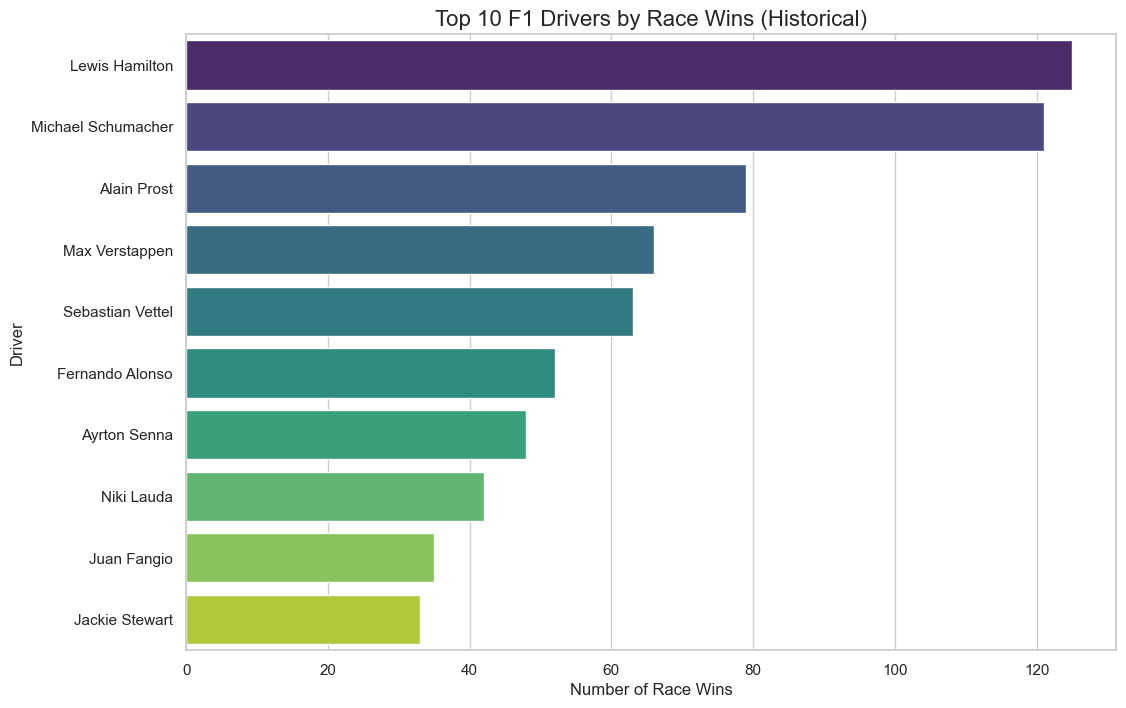

   - Top winners plot saved to f1_data\visualization_top_race_winners.png

2. Visualizing Fan Ratings Over Time...

An error occurred during ratings visualization: 'race_date'

3. Visualizing F1 Tweet Activity...

An error occurred during tweet visualization: 'created_at'

All Kaggle visualization tasks complete.


C:\Users\zengq\AppData\Local\Temp\ipykernel_39800\1829480061.py:28: DtypeWarning: Columns (5,6,7,12) have mixed types. Specify dtype option on import or set low_memory=False.
  tweets_df = pd.read_csv(TWEETS_FILE)


In [56]:
# Ensure the directory to save the visualization exists
os.makedirs(SAVE_PATH, exist_ok=True)
sns.set_theme(style="whitegrid")

print("--- Starting Kaggle Data Visualizations ---")

# --- Championship History Visualization ---
try:
    drivers_df = pd.read_csv(DRIVERS_FILE)
    results_df = pd.read_csv(RESULTS_FILE)
    plot_top_champions(drivers_df, results_df)
except FileNotFoundError:
    print(f"\nWarning: Championship history files not found in '{DATA_PATH}'. Skipping champions visualization.")
except Exception as e:
    print(f"\nAn error occurred during championship visualization: {e}")
        
# --- Fan Ratings Visualization ---
try:
    ratings_df = pd.read_csv(RATINGS_FILE)
    plot_fan_ratings_over_time(ratings_df)
except FileNotFoundError:
    print(f"\nWarning: Fan ratings file not found at '{RATINGS_FILE}'. Skipping ratings visualization.")
except Exception as e:
    print(f"\nAn error occurred during ratings visualization: {e}")

# --- Trending Tweets Visualization ---
try:
    tweets_df = pd.read_csv(TWEETS_FILE)
    plot_tweet_activity(tweets_df)
except FileNotFoundError:
    print(f"\nWarning: Trending tweets file not found at '{TWEETS_FILE}'. Skipping tweet activity visualization.")
except Exception as e:
    print(f"\nAn error occurred during tweet visualization: {e}")
print("\nAll Kaggle visualization tasks complete.")